# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt


In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    train_period = ast.literal_eval(config.get("train_period"))
    test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_consumer_good data paths
    lst_df_consumer_good_paths = ast.literal_eval(config.get("paths_df_consumer_good_processed"))
    

In [4]:
# Import data 
path = lst_df_consumer_good_paths[1]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df = df.dropna()

# **Split data**

In [7]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_train

,adClose_DBC,adClose_DLG,adClose_HHS,adClose_HNG,adClose_IDI,adClose_SBT,adClose_TNG,adClose_TSC,adClose_TTF,adClose_VNM
date,,,,,,,,,,
2020-04-13,8.921,1.54,2.471,12.70,3.346,11.520,7.405,1.969,2.10,69.827
2020-04-14,9.368,1.54,2.457,12.65,3.578,11.643,8.112,1.879,2.15,69.757
2020-04-15,9.935,1.63,2.623,12.80,3.634,11.643,8.692,1.924,2.16,69.898
2020-04-16,10.625,1.61,2.683,12.75,3.504,11.684,8.500,1.933,2.16,69.968
2020-04-17,11.355,1.60,2.835,12.75,3.606,12.219,8.371,2.067,2.15,69.968
...,...,...,...,...,...,...,...,...,...,...
2021-05-20,22.340,2.90,5.302,10.60,5.483,16.397,14.384,13.573,6.53,77.281
2021-05-21,23.052,2.92,5.311,10.55,5.855,16.907,14.677,13.573,6.78,78.334
2021-05-22,23.052,2.92,5.311,10.55,5.855,16.907,14.677,13.573,6.78,78.334


## **Gatev Data Normalization**

In [10]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [11]:
df_cum_daily_returns_train

,adClose_DBC,adClose_DLG,adClose_HHS,adClose_HNG,adClose_IDI,adClose_SBT,adClose_TNG,adClose_TSC,adClose_TTF,adClose_VNM
date,,,,,,,,,,
2020-04-14,5.010649,0.000000,-0.566572,-0.393701,6.933652,1.067708,9.547603,-4.570848,2.380952,-0.100248
2020-04-15,11.366439,5.844156,6.151356,0.787402,8.607292,1.067708,17.380149,-2.285424,2.857143,0.101680
2020-04-16,19.100998,4.545455,8.579522,0.393701,4.722056,1.423611,14.787306,-1.828339,2.857143,0.201928
2020-04-17,27.283937,3.896104,14.730878,0.393701,7.770472,6.067708,13.045240,4.977146,2.380952,0.201928
2020-04-18,27.283937,3.896104,14.730878,0.393701,7.770472,6.067708,13.045240,4.977146,2.380952,0.201928
...,...,...,...,...,...,...,...,...,...,...
2021-05-20,150.420356,88.311688,114.569000,-16.535433,63.867304,42.335069,94.247130,589.334688,210.952381,10.674954
2021-05-21,158.401524,89.610390,114.933225,-16.929134,74.985057,46.762153,98.203916,589.334688,222.857143,12.182966
2021-05-22,158.401524,89.610390,114.933225,-16.929134,74.985057,46.762153,98.203916,589.334688,222.857143,12.182966


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_DLG và adClose_SBT: 724.9
Khoảng cách Euclide của adClose_HHS và adClose_IDI: 478.5
Khoảng cách Euclide của adClose_HHS và adClose_TNG: 515.4
Khoảng cách Euclide của adClose_HNG và adClose_SBT: 829.5
Khoảng cách Euclide của adClose_HNG và adClose_VNM: 580.5
Khoảng cách Euclide của adClose_IDI và adClose_SBT: 559.0
Khoảng cách Euclide của adClose_IDI và adClose_TNG: 583.8
Khoảng cách Euclide của adClose_IDI và adClose_VNM: 813.7
Khoảng cách Euclide của adClose_SBT và adClose_TNG: 736.1
Khoảng cách Euclide của adClose_SBT và adClose_VNM: 475.4
[['adClose_DLG', 'adClose_SBT'], ['adClose_HHS', 'adClose_IDI'], ['adClose_HHS', 'adClose_TNG'], ['adClose_HNG', 'adClose_SBT'], ['adClose_HNG', 'adClose_VNM'], ['adClose_IDI', 'adClose_SBT'], ['adClose_IDI', 'adClose_TNG'], ['adClose_IDI', 'adClose_VNM'], ['adClose_SBT', 'adClose_TNG'], ['adClose_SBT', 'adClose_VNM']]


In [15]:
gatev_pairs

[['adClose_DLG', 'adClose_SBT'],
 ['adClose_HHS', 'adClose_IDI'],
 ['adClose_HHS', 'adClose_TNG'],
 ['adClose_HNG', 'adClose_SBT'],
 ['adClose_HNG', 'adClose_VNM'],
 ['adClose_IDI', 'adClose_SBT'],
 ['adClose_IDI', 'adClose_TNG'],
 ['adClose_IDI', 'adClose_VNM'],
 ['adClose_SBT', 'adClose_TNG'],
 ['adClose_SBT', 'adClose_VNM']]

# **Cointegration Approach**

## **Data Transformation**

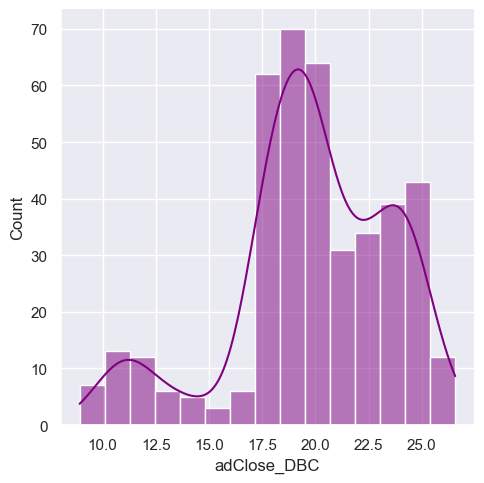

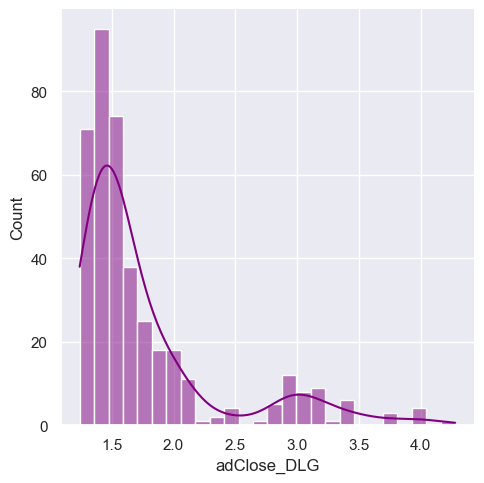

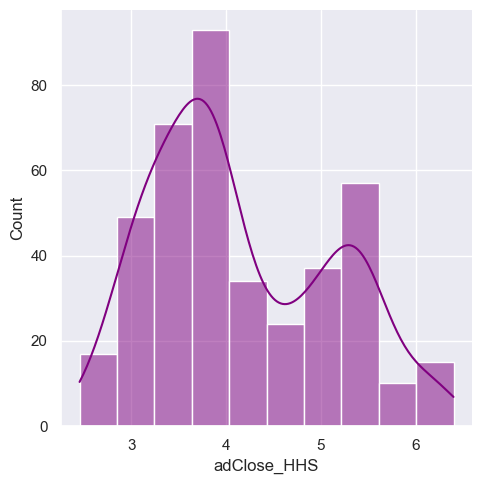

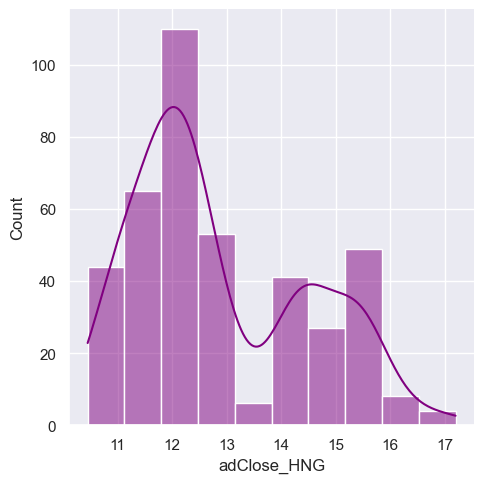

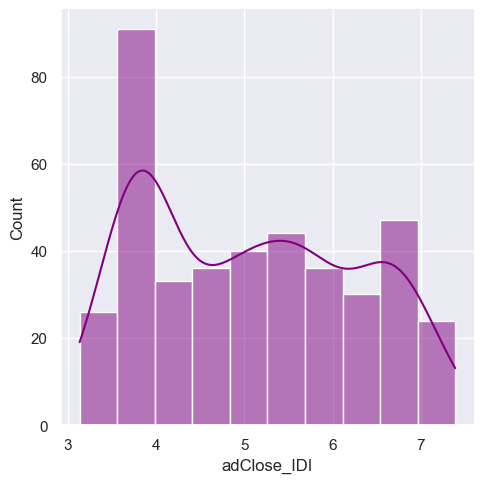

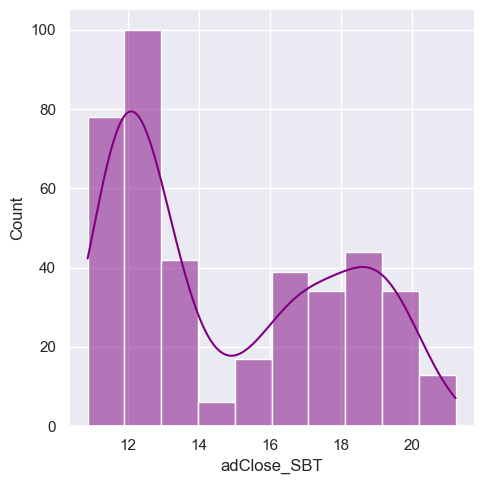

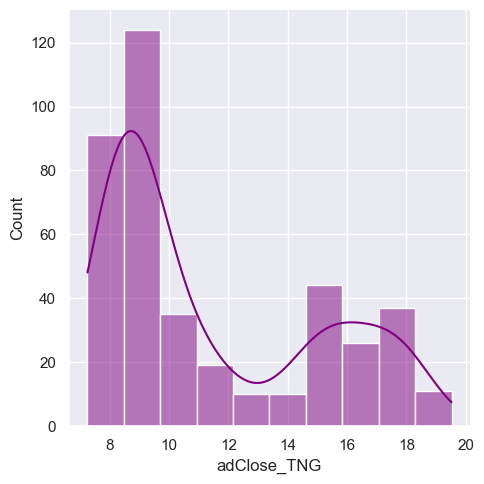

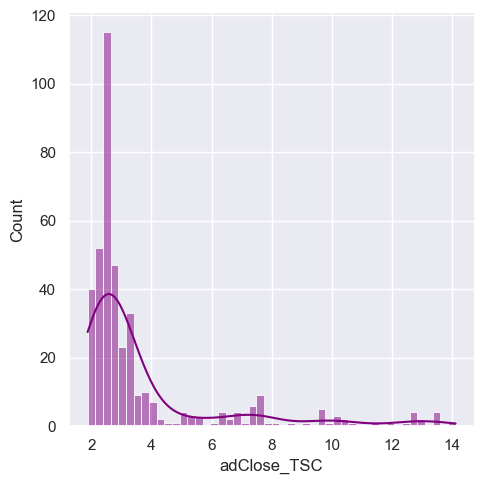

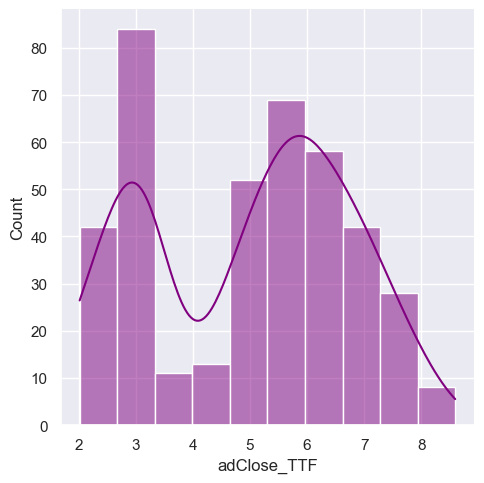

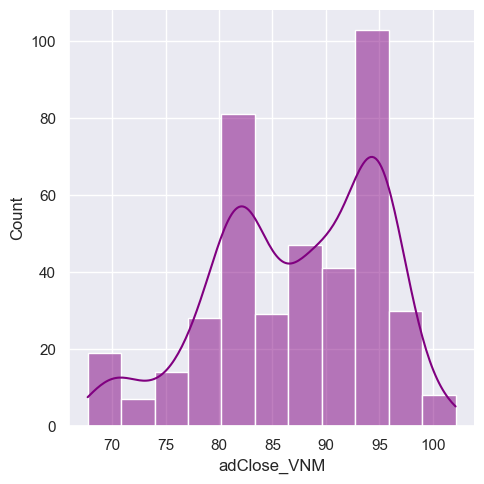

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [17]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_DBC,1
1,adClose_DLG,1
2,adClose_HHS,1
3,adClose_HNG,1
4,adClose_IDI,1
5,adClose_SBT,1
6,adClose_TNG,1
7,adClose_TSC,1
8,adClose_TTF,1
9,adClose_VNM,1


## **Engle - Grange Method**

C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\seaborn\matrix.py:198: RuntimeWarning:

All-NaN slice encountered

C:\Users\ADMIN\AppData\Roaming\Python\Python310\site-packages\seaborn\matrix.py:203: RuntimeWarning:

All-NaN slice encountered



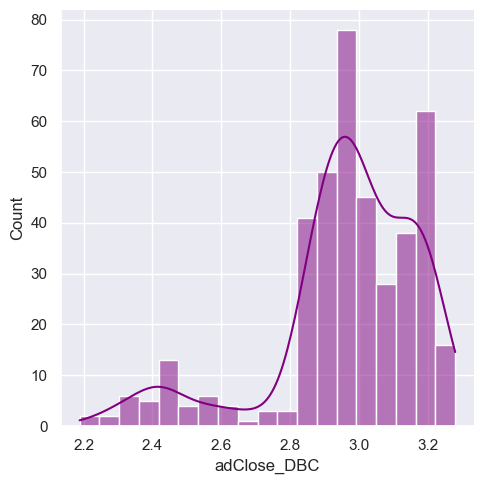

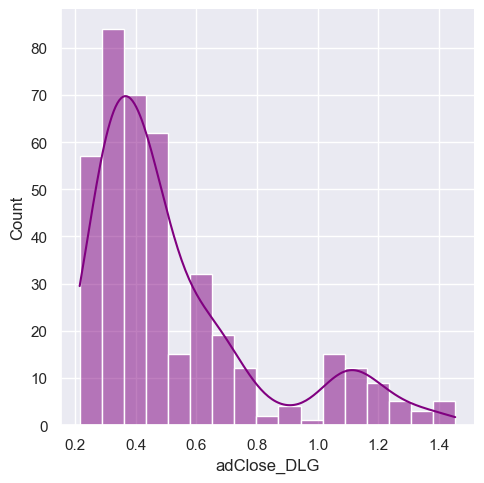

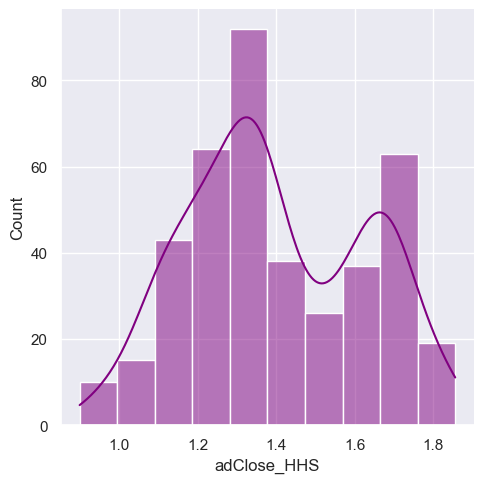

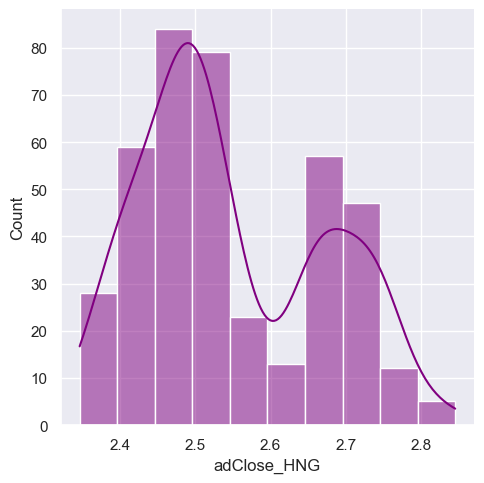

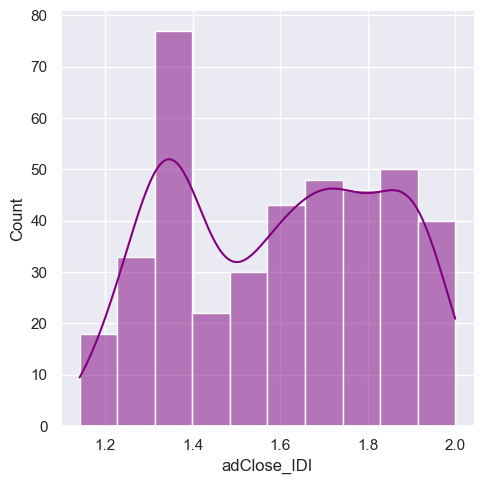

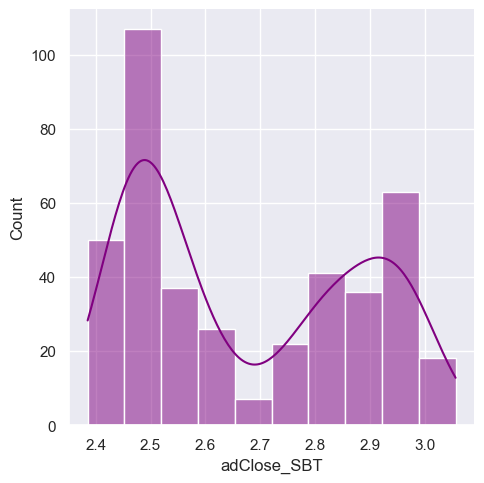

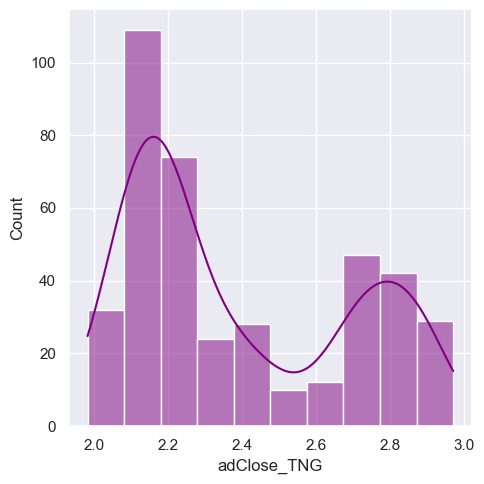

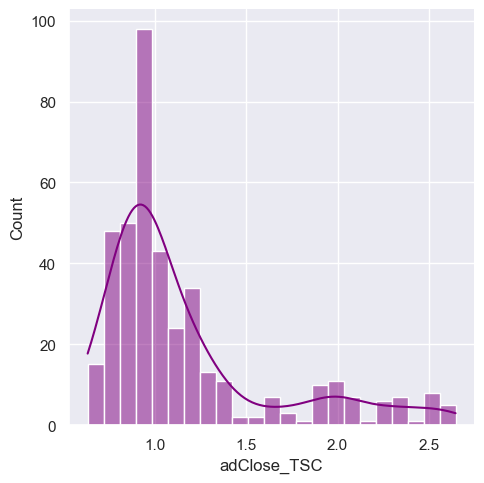

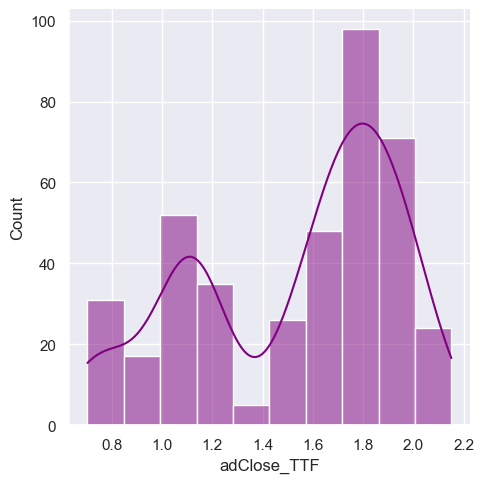

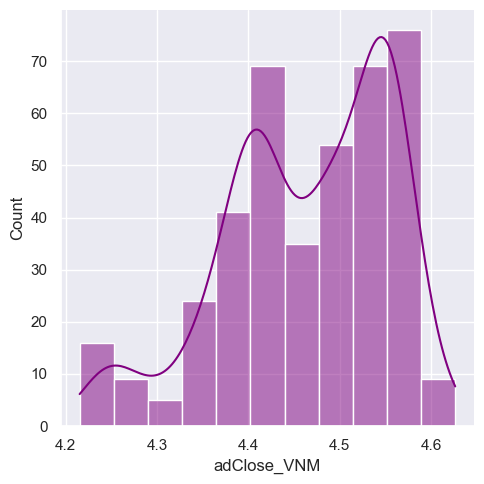

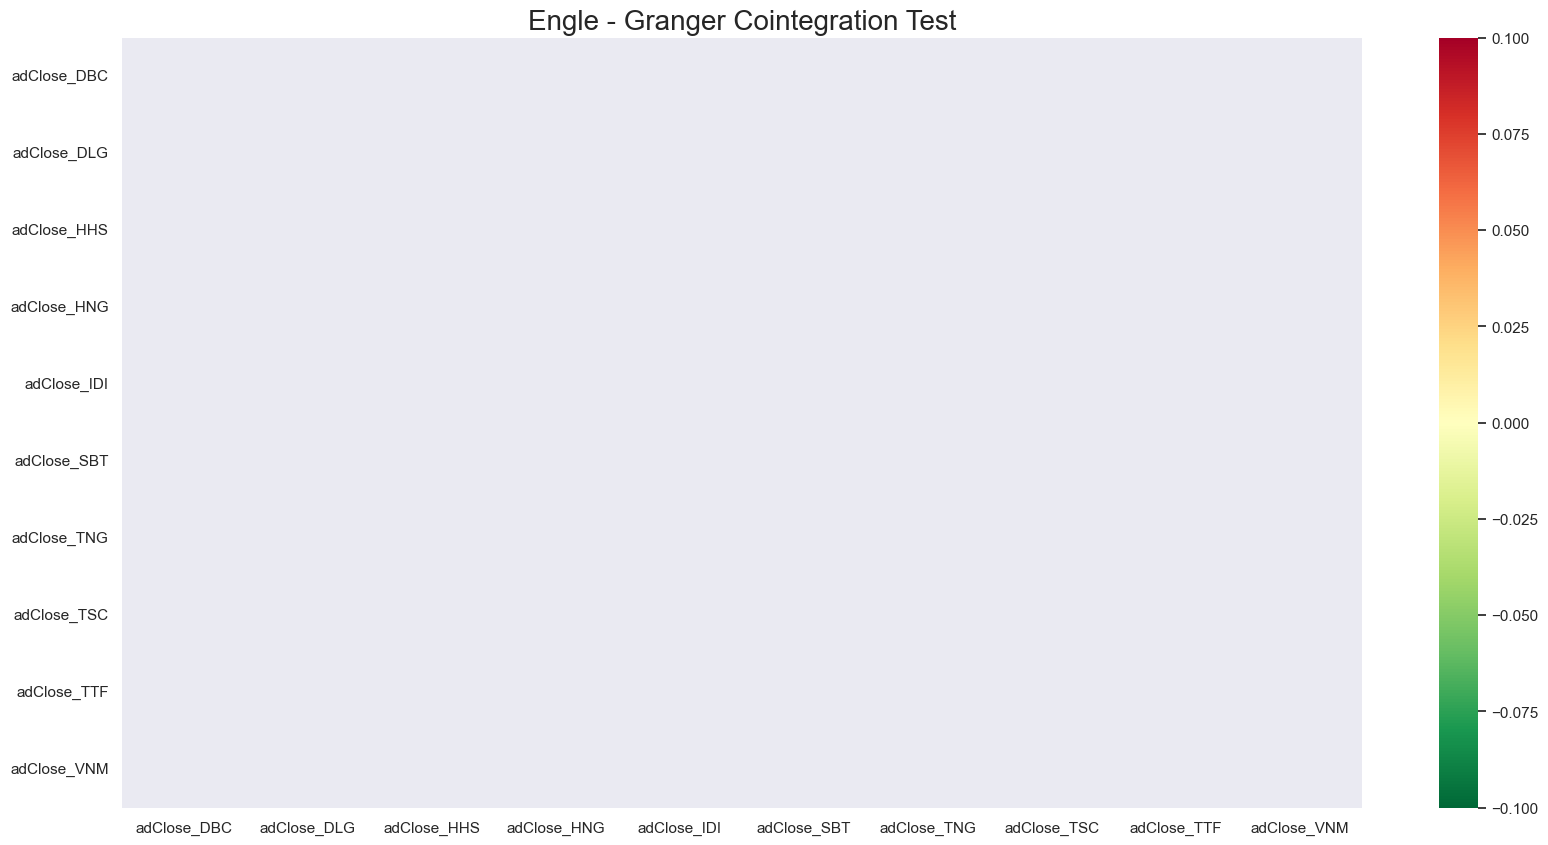

In [20]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [21]:
eg_pairs 

[]

In [22]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed, visualize = False)

In [23]:
eg_pairs_swap

[]

## **Johansen Method**

In [24]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [25]:
johansen_pairs

[['adClose_DBC', 'adClose_DLG'],
 ['adClose_DBC', 'adClose_HHS'],
 ['adClose_DBC', 'adClose_HNG'],
 ['adClose_DBC', 'adClose_TNG'],
 ['adClose_DBC', 'adClose_TSC'],
 ['adClose_DBC', 'adClose_VNM'],
 ['adClose_DLG', 'adClose_HHS'],
 ['adClose_DLG', 'adClose_VNM'],
 ['adClose_HNG', 'adClose_TSC'],
 ['adClose_TSC', 'adClose_VNM']]

# **Result Summary**

In [26]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [27]:
df_pairs_formation_train

,Stock A,Stock B,Johansen Pairs,Gatev Pairs,Count
0,adClose_DBC,adClose_DLG,x,,1
1,adClose_DBC,adClose_HHS,x,,1
2,adClose_DBC,adClose_HNG,x,,1
3,adClose_DBC,adClose_TNG,x,,1
4,adClose_DBC,adClose_TSC,x,,1
5,adClose_DBC,adClose_VNM,x,,1
6,adClose_DLG,adClose_HHS,x,,1
7,adClose_DLG,adClose_SBT,,x,1
8,adClose_DLG,adClose_VNM,x,,1
9,adClose_HHS,adClose_IDI,,x,1


In [28]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//consumer_good//consumer_good_pairs_formation_second_period_{hdt.today_date_to_digits()}.csv"
    )